In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

#### Calibrate the displacement noise

In [3]:
sphere = 'sphere_20251212'
folder = '20251215_electric_calibration_5e-8mbar_0'
file_prefix = '20251215_d_p8e_117khz_2vpp_lensholder1'

_files = [rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_0.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_1.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_2.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_3.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_4.hdf5']

c_mvs = utils.get_c_mv(_files, vp2p=[2, 2, 2, 2, 2], omegad=117000*2*np.pi, passband=(116700, 117300), searchband=(45000, 55000), charge=8, n_chunk=1, efield=138)
c_mv = np.mean(c_mvs)

print(f'c_mv: {c_mv}')

c_mv: 6.502615874975277e-08


Delta_p: 109.5803226441901 keV/c


(1e-28, 1e-18)

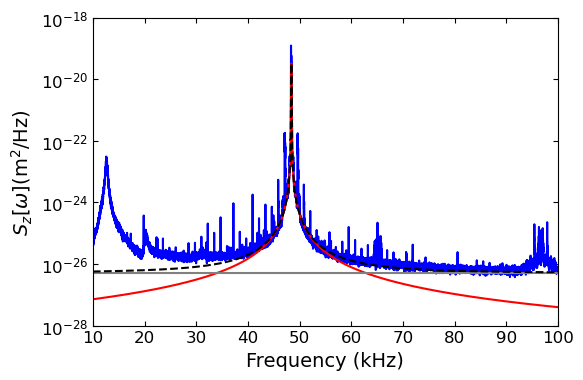

In [4]:
_file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/20251215_d_p8e_nodrive_4.hdf5'
ff, sz_measured, sf_measured, chi_2_convolved, dp_kev, fig, ax, voigt = utils.get_effective_force_noise(_file, c_mv, int_band=(30000, 90000), 
                                                                                                        fit_band=(44000, 60000), nperseg=2**20, plot_fit=True,
                                                                                                        p0=[2e-19, 48381*2*np.pi, 100*2*np.pi, 5*2*np.pi])
print(f'Delta_p: {dp_kev} keV/c')

_idx = np.logical_and(ff>200000, ff<250000)
sz_imp = np.mean(sz_measured[_idx])

ax.plot(np.linspace(10, 100, 50), np.full(50, sz_imp), 'gray')
ax.plot(ff/1000, voigt+sz_imp, 'k--')
ax.set_ylim(1e-28, 1e-18)

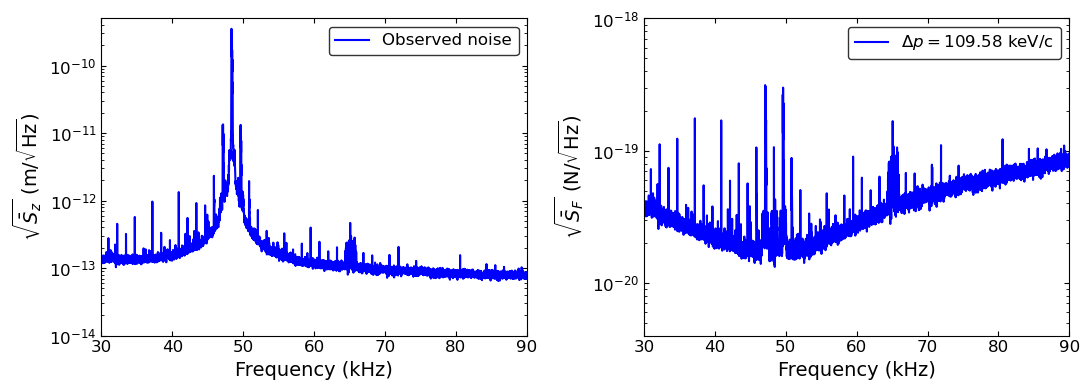

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(ff/1000, np.sqrt(sz_measured), color='b', label='Observed noise')
axes[1].plot(ff/1000, np.sqrt(sf_measured), color='b', label=fr'$\Delta p = {dp_kev:.2f}$ keV/c')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(30, 90)
    ax.set_xlabel('Frequency (kHz)')
axes[0].legend(edgecolor='k')
axes[1].legend(edgecolor='k')
axes[0].set_ylabel(r'$\sqrt{\bar{S}_{z}}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{\bar{S}_{F}}$ (N/$\sqrt{\mathrm{Hz}}$)')

axes[0].set_ylim(1e-14, 5e-10)
axes[1].set_ylim(4e-21, 1e-18)

fig.align_labels()
fig.tight_layout()

In [11]:
sphere = 'sphere_20251212'
dataset = '20251215_p8e_5e-8mbar_d137khz_0'

data_folder = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{dataset}'
data_prefix = '20251215_dfg_p8e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all_0 = []
amps_noise_0 = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = utils.get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=137000,
                            passband=(40000, 60000),
                            analysis_window_length=2**18,
                            prepulse_window_length=2**19,
                            search_window_length=250,
                            search_offset_length=20,
                            lowpass_freq=60000
                            )

    if v == 5:
        amps_noise_0 = utils.get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=137000,
                        passband=(40000, 60000),
                        analysis_window_length=2**18,
                        prepulse_window_length=2**19,
                        search_window_length=250,
                        search_offset_length=20,
                        lowpass_freq=60000
                        )
            
    amps_all_0.append(np.asarray(amps))

2.5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
Skipping pulse too close to the end of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
Skipping pulse too close to the end of file
7.5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
Skipping pulse too close to the beginning of file
10
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
Skipping pulse too close to the beginning of file
Skipping pulse too close to t

In [12]:
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])

bins = np.arange(0, 3000, 50) / 13872.016374453086
hhs, bcs, gps = utils.fit_amps_gaus(amps_all_0, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise_0], bins=bins, noise=True, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

print('amp2kev:', amp2kev_all)

amp2kev: 12771.38153768052


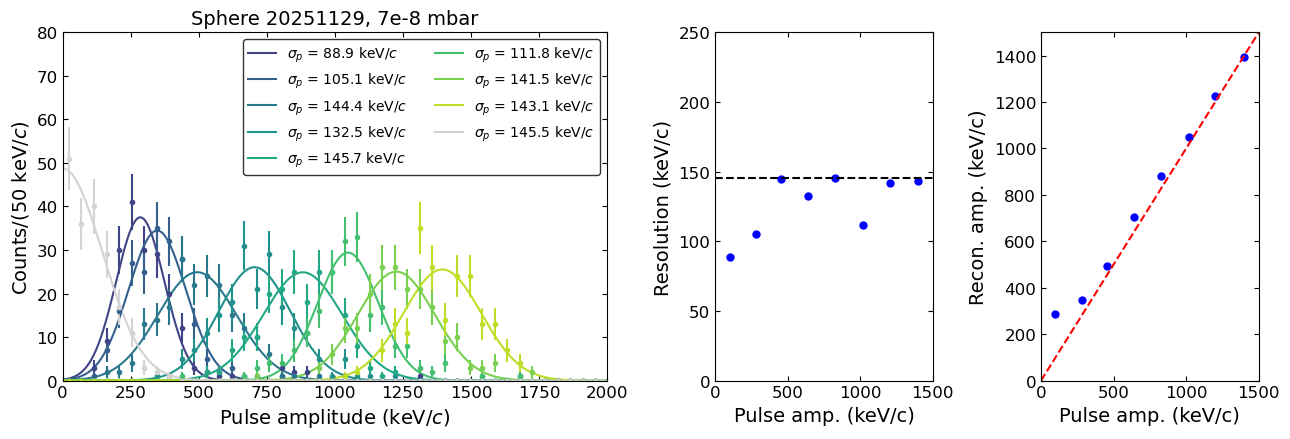

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), width_ratios=[2.5, 1, 1])

xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(pulse_amp.size):
    axes[0].errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    axes[0].plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

axes[0].errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
axes[0].plot(xx*amp2kev_all, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

axes[0].set_xlim(0, 2000)
axes[0].set_ylim(0, 80)
axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
axes[0].set_ylabel(r'Counts/(50 keV/$c$)')
axes[0].set_title('Sphere 20251129, 7e-8 mbar')

axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev_all, 'b.', markersize=10)
axes[1].set_xlim(0, 1500)
axes[1].set_ylim(0, 250)
axes[1].set_xlabel('Pulse amp. (keV/c)')
axes[1].set_ylabel('Resolution (keV/c)')
axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev_all, 'b.', markersize=10)
axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
axes[2].set_xlim(0, 1500)
axes[2].set_ylim(0, 1500)
axes[2].set_xlabel('Pulse amp. (keV/c)')
axes[2].set_ylabel('Recon. amp. (keV/c)')

fig.tight_layout()

#### Detailed look at impulse reconstruction

In [3]:
sphere = 'sphere_20251212'
dataset = '20251215_p8e_5e-8mbar_d137khz_0'

data_folder = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{dataset}'
data_prefix = '20251215_dfg_p8e_200ns_20v_'

combined_path = os.path.join(data_folder, f'{data_prefix}*.hdf5')
data_files = glob.glob(combined_path)

In [4]:
data_file = data_files[0]

dtt, nn = utils.load_timestreams(data_file, ['D', 'G'])
fs = int(np.ceil(1 / dtt))
zz, dd = nn[0], nn[1]

As before, first apply a loose bandpass filter. Here from 30 to 80 kHz.

In [5]:
bandpass_lb, bandpass_ub = (35000, 70000)
zz_bp = utils.bandpass_filtered(zz, fs, bandpass_lb, bandpass_ub, order=3)

positive_pulse = True
trigger_level = 0.5 * positive_pulse
pulse_idx = utils.get_pulse_idx(dd, trigger_level, positive_pulse)

(10.0, 100.0)

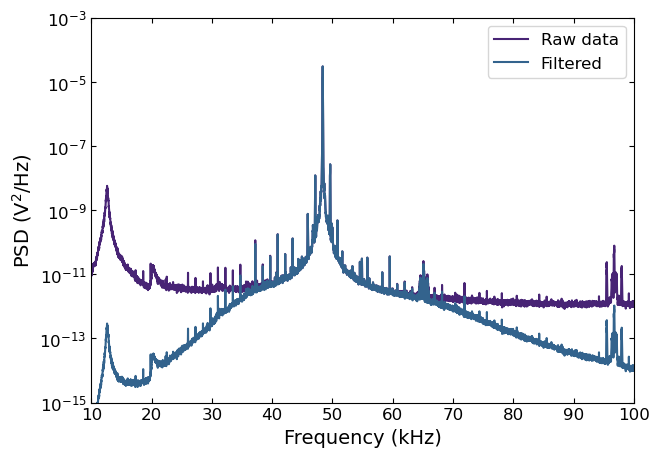

In [6]:
ff, pp = welch(zz, fs=fs, nperseg=2**19)
ff_bp, pp_bp = welch(zz_bp, fs=fs, nperseg=2**19)

plt.plot(ff/1000, pp, label='Raw data')
plt.plot(ff_bp/1000, pp_bp, label='Filtered')

plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')
plt.yscale('log')
plt.ylim(1e-15, 1e-3)
plt.xlim(10, 100)


Choose an analysis window for each pulse to fit for z frequency

In [7]:
window_lengths = np.asarray([2**15, 2**16, 2**17, 2**18, 2**19, 2**20])
freqs = []

for j, window_length in enumerate(window_lengths):
    freq = np.empty(pulse_idx.size)
    prepulse_window_length = window_length
    for i, idx in enumerate(pulse_idx):
        prepulse_window = utils.get_prepulse_window(dd, idx, prepulse_window_length)

        zzk = rfft(zz_bp[prepulse_window])
        ff = rfftfreq(zz_bp[prepulse_window].size, dtt)
        pp = np.abs(zzk)**2 / (zz_bp[prepulse_window].size / dtt)

        freq[i] = ff[np.argmax(pp)]
        
    freqs.append(freq)

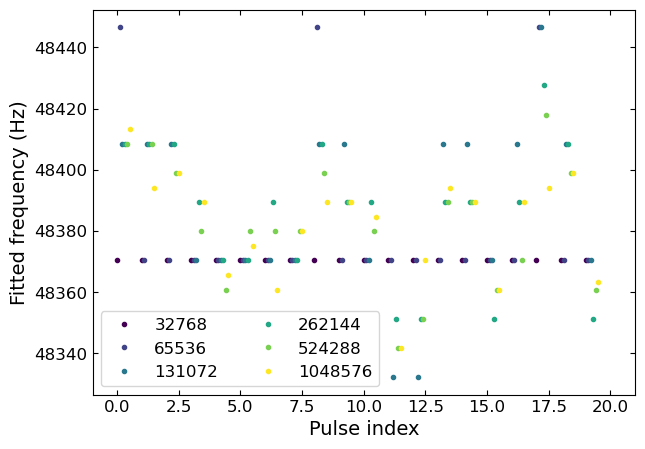

In [8]:
cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 6))

for i in range(len(freqs)):
    plt.plot(np.arange(0, 20) + i*0.1, freqs[i], '.', label=f'{window_lengths[i]}', color=colors[i])

plt.xlim(-1, 21)
plt.xlabel('Pulse index')
plt.ylabel('Fitted frequency (Hz)')
plt.legend(ncol=2)

Next choose an analysis window around each pulse

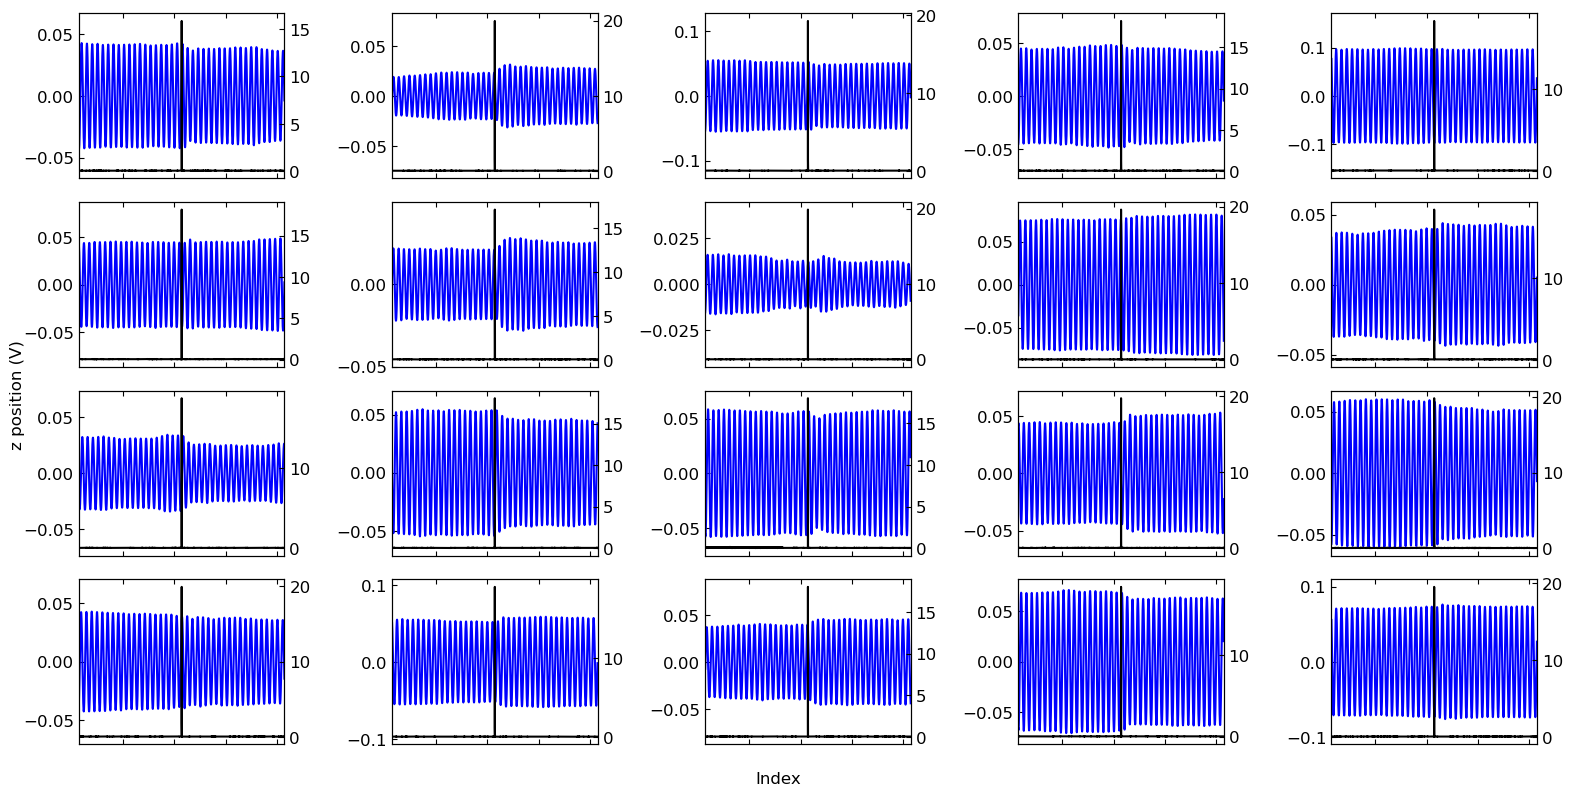

In [12]:
analysis_window_length = 2**18
fig, axes = plt.subplots(4, 5, figsize=(16, 8))

for i in range(20):
    idx = pulse_idx[i]
    window, pulse_idx_in_window = utils.get_analysis_window(dd, idx, analysis_window_length)

    ax = axes[i%4][i%5]
    ax.plot(zz_bp[window], 'b')
    ax.twinx().plot(dd[window], 'k')

    ax.set_xlim(pulse_idx_in_window-2000, pulse_idx_in_window+2000)
    ax.set_xticklabels([])

fig.supxlabel('Index')
fig.supylabel('z position (V)')
fig.tight_layout()